# Preambule 
***

### Load necessary packages

In [625]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,10)})

### Functions used 

In [626]:
# Function correcting date and time form (ie changes '2014-10-11 25:41:20' to '2014-10-12 1:41:20')
def correct_time(dataframe):
    if type(dataframe['Time'][0]) != np.int64:
        dataframe['Datetime'] = dataframe['Date']+ pd.to_timedelta(dataframe['Time'])
        dataframe['Time'] = dataframe['Datetime'].dt.hour
        dataframe['Date'] = (dataframe['Datetime'].dt.date).apply(pd.to_datetime)
        return (dataframe.drop(['Datetime'], axis = 1))
    else:
        return dataframe
    
    
# Function transforming specific column to format more suitable for machine learning
def clean_column(dataframe, dataframe2, column_name, date):
    df = dataframe
    df1 = dataframe2
    d = date
    
    dummy = df1.loc[(df1['Date'] == pd.to_datetime(d)),]
    #dummy['Time'] = dummy['Datetime'].dt.hour
    dummy_sorted = dummy.pivot_table(index = ['Time', 'Date'], columns = column_name, aggfunc = 'size', fill_value = 0)
    dummy2 = df.loc[df['Date'] == d,]
    
    return pd.merge(dummy2, dummy_sorted, on = ['Time', 'Date'])


# Function transforming whole dataframe to more suitable form for machine learning
def clean_datasets(dataframe, dataframe2, names, dates):
    df = dataframe
    df1 = dataframe2
    intersection_dates = dates
    column_names = names
    
    df_cleaned = pd.DataFrame()

    for date in intersection_dates:
        df_date = clean_column(df, df1, column_names[0], date)
        df_date.head()

        for name in column_names[1:]:
            df_name = clean_column(df, df1, name, date)
            df_date = pd.merge(df_date, df_name, on = ['Time', 'Date', 'Wizyty_all'])
        
        df_cleaned = df_cleaned.append(df_date)

    df_cleaned = df_cleaned.fillna(0)
    
    if 'Timeband' in column_names:
        df_cleaned[df1['Timeband'].unique()] = df_cleaned[df1['Timeband'].unique()].astype(bool).astype(int)      
        
    for i in ['Campaign Channel', 'BreakType (Block type)', 'Position Type in the block of commercials']:
        if df1[i].unique()[0] in df_cleaned.columns.to_list():
            sums = df_cleaned[df1[i].unique()].sum(axis = 1)
            df_cleaned['Sum'] = sums
            del sums 
            return df_cleaned
    
    return df_cleaned

# Dataset exploring and transforming
***

## First we load data to dataframes and change labels for convenience, we add "_Datetime_" column for easier workflow with dates. We also check for any _NaNs_ in our dataset

### Loading

In [627]:
df = pd.read_excel('exemplary_data.xlsx', 0)
df = df.rename(columns = {'Data':'Date'}, inplace = False)
df = df.rename(columns = {'godzina':'Time'}, inplace = False)


df1 = pd.read_excel('exemplary_data.xlsx',1)

### Check _NaNs_

In [628]:
print([df.isnull().values.any(), df1.isnull().values.any()])

[False, False]


***
## Let's investigate dataset **df**

In [629]:
df

,Date,Time,Wizyty_all
0,2014-10-01,0,1589
1,2014-10-01,1,658
2,2014-10-01,2,299
3,2014-10-01,3,211
4,2014-10-01,4,257
...,...,...,...
2203,2014-12-31,19,2243
2204,2014-12-31,20,1844
2205,2014-12-31,21,1680
2206,2014-12-31,22,1538


### Here we can see that in every row we're given date, time and a number of visits on a website. We can see that our dataset covers 3 months between 2014-11-1 and 2014-12-31

In [630]:
print(len(df['Date'].unique()))
print(str(df['Date'].dt.date.min()) + ' to ' + str(df['Date'].dt.date.max()))

92
2014-10-01 to 2014-12-31


### Next thing that's quite useful to do is too see how daily traffic looks like. We do it by calculating average daily traffic

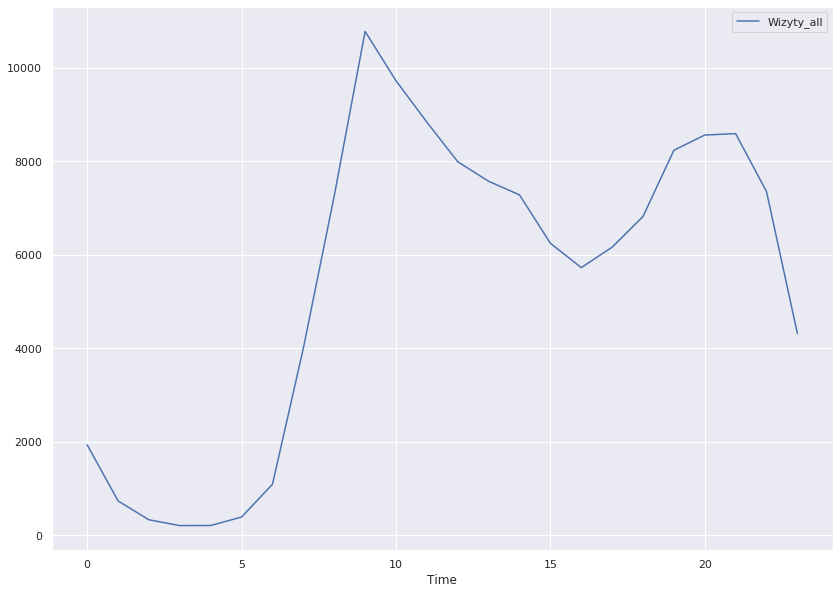

In [631]:
df.pivot_table(index = 'Time', values = 'Wizyty_all').plot()

### This behaviour is quite obvious - amount of visits is growing from aorund 6 am to 9 am, when people go to work, then when they are in work it decreases to around 5 pm and then it grows again to 9 pm. From this we should see quite easily that **Time** is going to be most important factor related to website traffic

### Another quite useful thing to check is autocorrelation of this time series

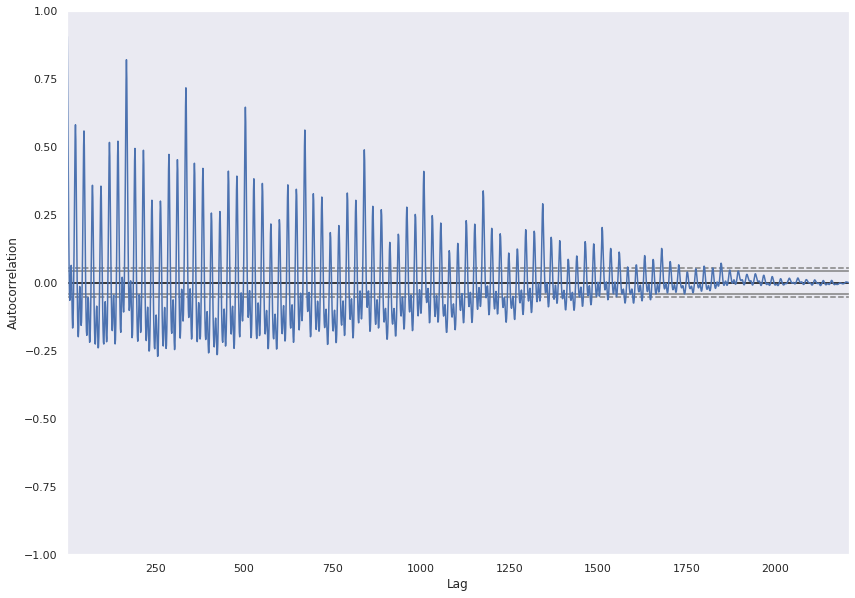

In [632]:
pd.plotting.autocorrelation_plot(df['Wizyty_all'])

### We can see that the amount of visits is very highly correlated
***

## Let's move now to the second dataset **df1**

In [633]:
df1

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.000000
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.000000
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.000000
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.000000
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.000000
...,...,...,...,...,...,...,...,...,...,...
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-23,24:32:15,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-23,24:46:21,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-23,25:11:09,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,25:26:59,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207


### We can see that we have quite a lot of informations here, but first thing that we see is a problem in **Time** column - it appears that in some cases days are longer than 24 hours. We correct it with function _correct time_. 

### This function also takes just hour part of time and set it as new variable **Time** - we do it, because in **df** we have only hourly number of visitors - as well as makes sure, that **Date** variable is the same kind of object as **Date** in **df**

In [634]:
df1  = correct_time(df1)

In [635]:
df1

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,6,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.000000
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,6,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.000000
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,6,Day,Between,TELEDYSKI,Middle,30,0.000000
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,6,Day,Between,PIMP MY RIDE,Middle,30,0.000000
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,6,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.000000
...,...,...,...,...,...,...,...,...,...,...
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-24,0,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-24,0,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-24,1,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-24,1,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207


### First thing that we want to do is to check time range covered by this dataset

In [636]:
print(len(df1['Date'].unique()))
print(str(df1['Date'].dt.date.min()) + ' to ' + str(df1['Date'].dt.date.max()))

15
2014-11-10 to 2014-11-24


### We see that this dataset covers 2 weeks between 2014-10-01 and 2014-11-24. If we want to analyse relationship between commercials and a number of visitors, we have to restrict dataset **df** to time range covered by **df1**. We see that fortunetely every day from **df1** is covered by **df**

### Now let us see what kind of informations we can get out of commercial dataset **df1**. Obvious thing to check is if **Commerical length** has some unique numbers or is it just one number **30**. After checking we see that it's just that one number, so we drop it - it's worthless during analysis

In [637]:
print(df1['Commercial length'].unique())
df1 = df1.drop(['Commercial length'], axis = 1)

[30]


In [638]:
df1

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,GRP
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,6,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,0.000000
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,6,Day,After,LOKATORZY /SER.KOM.POL./,Middle,0.000000
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,6,Day,Between,TELEDYSKI,Middle,0.000000
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,6,Day,Between,PIMP MY RIDE,Middle,0.000000
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,6,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,0.000000
...,...,...,...,...,...,...,...,...,...
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-24,0,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,0.000000
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-24,0,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,0.000000
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-24,1,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,0.000000
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-24,1,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,0.525207


### Next thing that's useful to check are statistic of **Break type**, **Timeband** and **Position type**. As we can see on histograms most of the commercials were emitted during day and in the middle of the block.

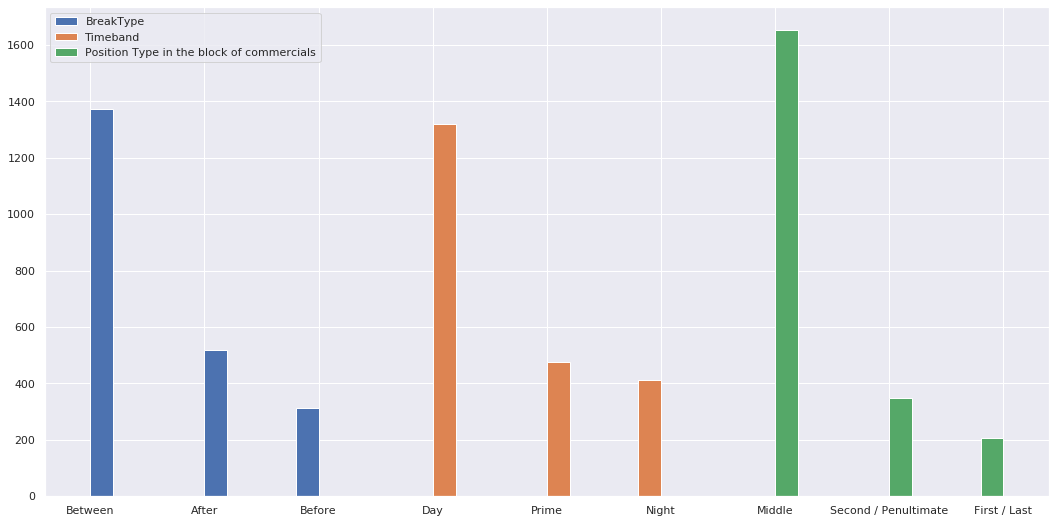

In [639]:
plt.figure(figsize = (18,9))
df1['BreakType (Block type)'].hist()
df1['Timeband'].hist()
df1['Position Type in the block of commercials'].hist()
plt.legend(['BreakType','Timeband','Position Type in the block of commercials'])
plt.show()

### Another thing we can do is take a look how many commercials were emitted during day in every hour. We see that for every hour amount of commercials is *more or less* the same.

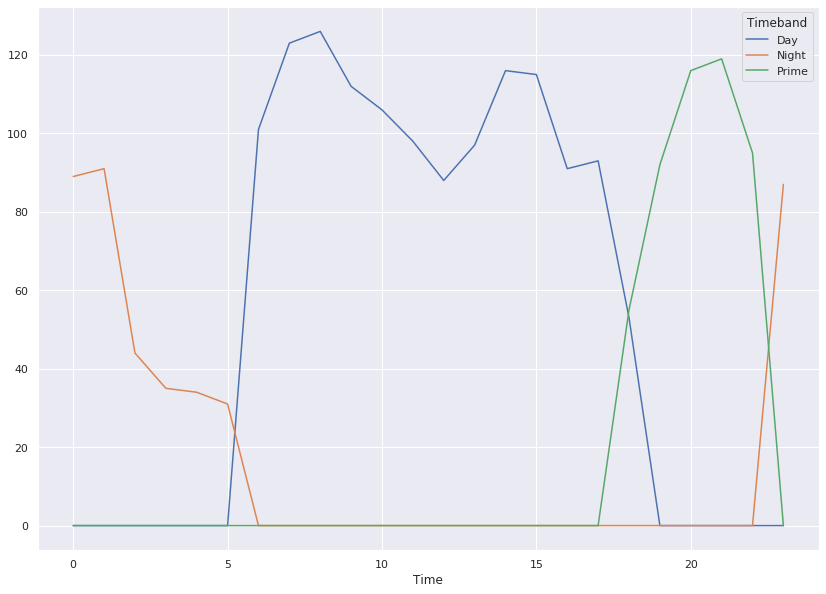

In [640]:
df1.pivot_table(index = 'Time', columns = 'Timeband', fill_value=0, aggfunc = 'size').plot()

### Next thing we have to do is to combine both of our datasets in a way that allow us to link statistics of emitted commercials with a number of visitors. To do that we first create a list of dates that are covered by dataset **df1**

In [641]:
idx = pd.Index(df['Date'].unique())
idx1 = pd.Index(df1['Date'].unique())
intersection_dates = [i for i in idx.intersection(idx1)]
[str(i.date()) for i in intersection_dates]

['2014-11-10',
 '2014-11-11',
 '2014-11-12',
 '2014-11-13',
 '2014-11-14',
 '2014-11-15',
 '2014-11-16',
 '2014-11-17',
 '2014-11-18',
 '2014-11-19',
 '2014-11-20',
 '2014-11-21',
 '2014-11-22',
 '2014-11-23',
 '2014-11-24']

### And then we use function *clean_datasets* to transform it to the form we can use in our model, as arguments this function takes dataset with visitors **df**, dataset with commercials statistics **df1**, names of columns from commercials dataset **column_names** and dates appearing in both datasets **intersection dates**. 

### To derive features we calculate:
 * how many commercials from specific **Campaign channel appear** at every hour appear - 7 features
 * during which **Timeband** commercials are emitted - 3 features
 * how many commercials during what kind of **Break type**  are emitted - 3 features
 * how many commercials with a specific **Position type in the block of commercials** are emitted - 3 features

### Why are we not using other columns?
 * **Title** - 893 unique positions,
 * **AGB Channel** - 59 unique positions,
 * **GRP** - 407 unique positons

### Main reason is the size of our dataset - only 327 rows! We have to stick to smaller amount of features. Equiped with a dataset of a bigger size we could use also other features.

### We finally end up with transformed dataset

In [642]:
column_names = [
 'Campaign Channel',
 'Timeband',
 'BreakType (Block type)',
 #'Title',
 'Position Type in the block of commercials',
 #'GRP'
]

In [643]:
df_cleaned = clean_datasets(df, df1, column_names, intersection_dates)
df_cleaned

,Date,Time,Wizyty_all,Polsat,Polsat Pakiet Tematyczny,TVN,TVN Pakiet Tematyczny,TVP Pakiet Tematyczny,TVP1,TVP2,Day,Night,Prime,After,Before,Between,First / Last,Middle,Second / Penultimate,Sum
0,2014-11-10,6,1070,0.0,1,0,5,1.0,0.0,0.0,1,0,0,1,0.0,6,0.0,5,2,7.0
1,2014-11-10,7,3086,0.0,9,0,4,4.0,0.0,0.0,1,0,0,7,1.0,9,3.0,11,3,17.0
2,2014-11-10,8,5989,0.0,5,0,6,2.0,0.0,1.0,1,0,0,2,3.0,9,4.0,8,2,14.0
3,2014-11-10,9,11506,0.0,6,1,5,3.0,1.0,1.0,1,0,0,5,1.0,11,2.0,14,1,17.0
4,2014-11-10,10,9680,0.0,6,0,6,3.0,0.0,0.0,1,0,0,1,3.0,11,5.0,8,2,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2014-11-23,21,12314,0.0,1,1,0,1.0,1.0,1.0,0,0,1,2,0.0,3,0.0,5,0,5.0
20,2014-11-23,22,9515,0.0,0,0,4,1.0,1.0,0.0,0,0,1,2,0.0,4,0.0,6,0,6.0
21,2014-11-23,23,6180,0.0,0,0,4,0.0,0.0,0.0,0,1,0,0,1.0,3,0.0,4,0,4.0
0,2014-11-24,0,2409,0.0,0,0,5,0.0,0.0,0.0,0,1,0,2,0.0,3,0.0,5,0,5.0


### With this it's quite useful to see correlation matrix for our dataset. We can see here what was to be expected - **Time** is quite higly correlated with number of visits **Wizyty_all**

In [644]:
df_cleaned.drop('Date', axis = 1).corr().style.background_gradient()

,Time,Wizyty_all,Polsat,Polsat Pakiet Tematyczny,TVN,TVN Pakiet Tematyczny,TVP Pakiet Tematyczny,TVP1,TVP2,Day,Night,Prime,After,Before,Between,First / Last,Middle,Second / Penultimate,Sum
Time,1.000000,0.523530,0.121770,-0.022133,0.006106,0.329878,0.021166,0.052891,0.043220,0.039653,-0.541251,0.627653,0.272973,0.034563,0.130063,-0.002423,0.266571,-0.001299,0.206188
Wizyty_all,0.523530,1.000000,0.012244,-0.024057,0.086214,0.184899,0.005006,0.123341,0.153478,0.284682,-0.595115,0.339662,0.165892,0.010764,0.099943,0.005325,0.140062,0.080892,0.137347
Polsat,0.121770,0.012244,1.000000,0.101610,0.047010,0.003129,0.015372,-0.008411,0.091424,0.078597,-0.132041,0.009974,0.061421,0.039171,0.205682,0.007104,0.180132,0.122829,0.182988
Polsat Pakiet Tematyczny,-0.022133,-0.024057,0.101610,1.000000,-0.045203,0.162626,0.196960,0.147636,-0.000700,0.184375,-0.133854,-0.072940,0.268237,0.183569,0.759999,0.472179,0.574069,0.391338,0.703103
TVN,0.006106,0.086214,0.047010,-0.045203,1.000000,-0.014176,0.067374,0.055015,0.080729,-0.034478,-0.026536,0.039539,0.056843,0.139650,0.059947,0.053960,0.090421,0.063545,0.105934
TVN Pakiet Tematyczny,0.329878,0.184899,0.003129,0.162626,-0.014176,1.000000,0.055929,0.068069,0.006734,0.123177,-0.322749,0.270846,0.418066,0.192463,0.634483,0.105943,0.688534,0.322062,0.671223
TVP Pakiet Tematyczny,0.021166,0.005006,0.015372,0.196960,0.067374,0.055929,1.000000,0.065081,0.121097,0.121312,-0.150956,0.016811,0.440192,0.674508,0.186829,0.280637,0.414167,0.307077,0.499507
TVP1,0.052891,0.123341,-0.008411,0.147636,0.055015,0.068069,0.065081,1.000000,0.092041,0.214555,-0.236670,0.000245,0.317909,0.251763,0.126472,0.080274,0.221783,0.272294,0.284830
TVP2,0.043220,0.153478,0.091424,-0.000700,0.080729,0.006734,0.121097,0.092041,1.000000,0.179249,-0.177375,-0.014338,0.209825,0.271141,0.054652,0.087914,0.142476,0.191862,0.198335
Day,0.039653,0.284682,0.078597,0.184375,-0.034478,0.123177,0.121312,0.214555,0.179249,1.000000,-0.680878,-0.386126,0.197341,0.193241,0.180651,0.136862,0.208420,0.188248,0.261466


### We can also get some insight from looking at histogram of **Campaign Channel** columns of **df_cleaned**. Here we see that some small numbers of commercials were emitted by *TVP1*, *TVP2*, *TVN* and *Polsat*. Crushing majority of them were emitted by *Polsat Pakiet Tematyczny*, *TVN Pakiet Tematyczny* and *TVP Pakiet Tematyczny*

<Figure size 1296x648 with 0 Axes>

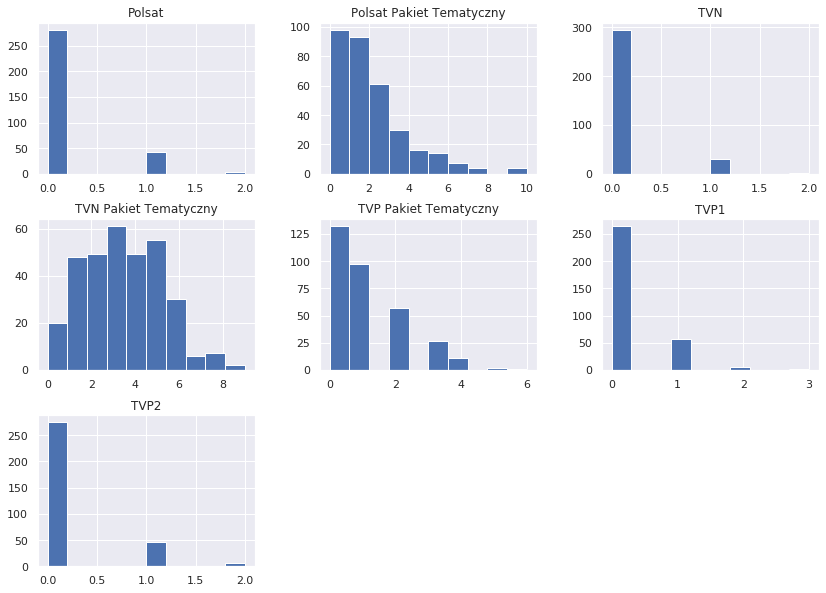

In [645]:
ax = plt.figure(figsize = (18,9))
df_cleaned[df1['Campaign Channel'].unique()].hist()
plt.show()

***

# Model

### As our model we used Random Forest following parameters. These parameters were found through randomized search on hyperparameters space by a function **RandomizedSearchCV** from *sklearn* package. Code for it can be found at the end

In [646]:
best_params = {'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

### Before training our model first we have to drop non-numerical column **Date** and normalize our dataset. We do it by **MinMaxScaler** function from sklearn package. After that we take **Wizyty_all** column as our target variable and rest of the columns as our features. We split our dataset with **train_test_split**

In [647]:
df_reg = df_cleaned.drop(['Date'], axis = 1)

scaler=MinMaxScaler()
df_reg[df_reg.columns] = scaler.fit_transform(df_reg[df_reg.columns])

X = df_reg.drop(['Wizyty_all'], axis = 1)

y = df_cleaned['Wizyty_all']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

### We pass previously written best parameters as arguments in **RandomForestRegressor** and then we fit it on train data and calculate score on test data as well as calculate cross-validation score

In [648]:
reg = RandomForestRegressor(**best_params)

reg.fit(X_train, y_train)
sc_train = reg.score(X_train, y_train)
sc_test = reg.score(X_test, y_test)
sc_cv = cross_val_score(reg, X, y, scoring='r2')

### Results of our model

In [649]:
print("R^2 on train: {} \nR^2 on test: {} \nR^2 of cross val: {}\nMean of R^2 for cross val {}:".format(sc_train, sc_test, sc_cv, sc_cv.mean()))
features_series = pd.Series(data=reg.feature_importances_, index = X.columns).sort_values(ascending=False)
#pd.DataFrame(data=reg.feature_importances_, index = X.columns).drop('Time', axis = 0).plot()
features_series[:10]

R^2 on train: 0.7756555754291511 
R^2 on test: 0.5127146122886919 
R^2 of cross val: [0.42486262 0.64168839 0.58568774 0.43288821 0.05916023]
Mean of R^2 for cross val 0.42885743911099283:


Time                        0.708971
Polsat Pakiet Tematyczny    0.046252
Sum                         0.030969
Middle                      0.030300
TVN Pakiet Tematyczny       0.030287
After                       0.026602
Between                     0.020390
Prime                       0.016175
TVP Pakiet Tematyczny       0.015957
Second / Penultimate        0.012803
dtype: float64

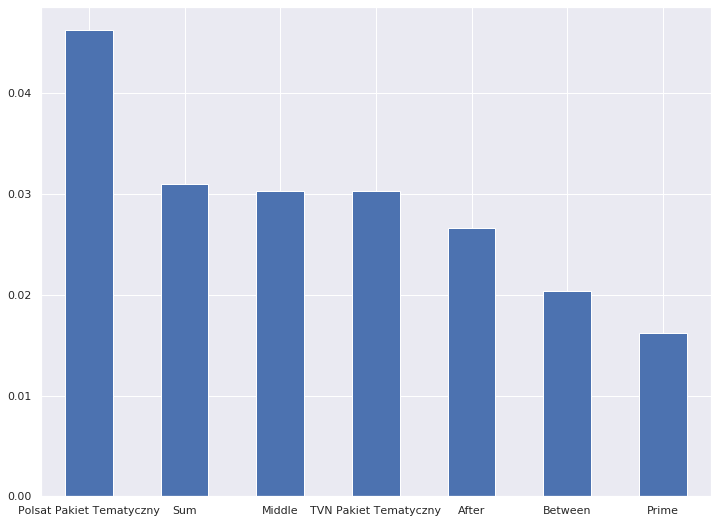

In [651]:
plt.figure(figsize = (12,9))
features_series.drop('Time', axis = 0)[:7].plot.bar(rot = 0)
plt.savefig('features.jpg')

***
## Randomized cross val search for parameters

In [654]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_